# Nonlinear least squares (with one parameter)
### This code estimates the model $$y_t = \theta^{x_t} + \varepsilon_t$$ using a NLS estimator. 

In [1]:
import os
from platform import python_version
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize

# The recommended python version is 3.8 or 3.9
print(python_version())
# Check current directory
os.getcwd()


3.8.5


'/Users/Fbandi/Dropbox/nonlineareconometrics2024/FEDERICO/Python_codes'

### We are simulating the data. We will set the parameter value as being equal to $2$ and both $x_t$ and $e_t$ as being normal with certain means and variances. Given the parameter value, $x_t$ and $e_t$, the model will yield $y_t.$ Of course, all quantities can be easily modified. 

In [2]:
# sample size
sample_size = 1000        # Choose the number of observations in the sample - you can increase the number to see if the LLN works

# population parameters
mean_of_x = 2             # mean of the regressor
variance_of_x = 4         # variance of the regressor
variance_of_e = 1000      # variance of the residual

# The parameter value
theta = 2

# generate x as a sample from the Normal distribution
x = np.random.normal(mean_of_x, np.sqrt(variance_of_x), sample_size)

# generate the residuals as a sample from Normal distribution
e = np.random.normal(0, np.sqrt(variance_of_e), sample_size)

# generate y using the formula
y =  theta**x + e

### Let us look at the data first. We want to make sure that we have generated enough dispersion (through the variance of the residuals) around the curve. In other words, we do not want all of the observations y and x to exactly sit on a curve. We want the model to be realistic.

Text(0.5, 1.0, 'A scatterplot of the data')

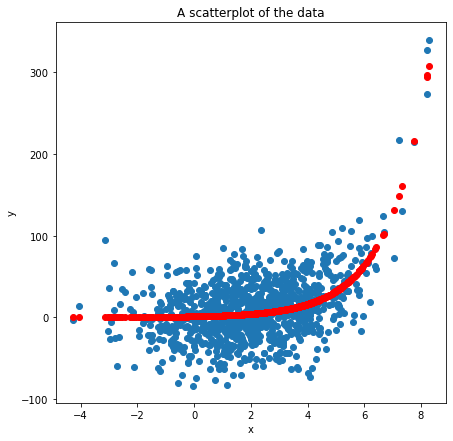

In [3]:
# Adjust the plot size on your computer
plt.rcParams['figure.figsize'] = [7, 7]

# A scatterplot with matplotlib
plt.xlabel('x')
plt.ylabel('y')
plt.scatter(x, y) 
plt.scatter(x, theta**x, color = 'red')
plt.title('A scatterplot of the data')

### Now that we have the data, we are ready to begin. Let us go step by step.

### (1) We define the least-squares criterion in a `Python function` called `nls`. The criterion is:

\begin{eqnarray*}
&&\frac{1}{T} \sum_{t=1}^T \varepsilon_t^2 \\
&=& \frac{1}{T} \sum_{t=1}^T  \left(y_t  - \theta^{x_t} \right)^2.\\
\end{eqnarray*}

In [4]:
def nls(parameter, y, x):
    f =  np.mean( (y -  parameter** x )**2  )
    return f

### (2) We now minimize the function with respect to $\theta:$

\begin{eqnarray*}
\widehat{\theta} &=& \arg\min_{\theta}  \frac{1}{T} \sum_{t=1}^T \varepsilon_t^2 \\
&=&  \arg\min_{\theta} \frac{1}{T} \sum_{t=1}^T  \left(y_t  - \theta^{x_t} \right)^2\\
\end{eqnarray*}

### In order to do so we have to feed the function into a minimizer: another function which will compute the minimum of the criterion. A possible function is `scipy.optimize.fmin`. 

The inputs of the `scipy.optimize.fmin` function are:

1. `func`. The function to minimize - in our case `nls` - as defined in the previous snippet.
2. `x0`. The initial guess of the parameters $\theta$: `initial_guess`. This is just our initial guess of the parameter for evaluating the function `nls` at the beginning of the minimization.
3. `args`. The arguments of the `nls` function that are not parameters. For our problem, these are the data $y_t,x_t$ with $t=1,\cdots, T$, contained in `y` and `x`, respectively.

Additional inputs that are optional:

4. `xtol` and `ftol`. This is the tolerance for the minimizer and the function evaluation, respectively. The algorithm will stop automatically when it cannot find another minimizer that is smaller by at least `xtol` than the current one. Same as for the function evaluation. 
5. `maxiter`. The maximum number of iterations to try. The algorithm stops if it reaches `maxiter` attempts, even if it did not find a minimum.
6. `disp`. A variable indicating whether we want to see some results or not. `disp=0` will not show results, `disp=1` will provide additional information.

In [5]:
initial_guess = 1
estimates = scipy.optimize.fmin(func=nls, 
                                x0=initial_guess, 
                                args=(y, x), 
                                xtol=1e-5, 
                                ftol=1e-5, 
                                maxiter = 1000000, 
                                disp=0
                                )  

print(f'The parameter estimate is {estimates[0]:.3f}')

The parameter estimate is 2.005


### Inference in Nonlinear Least Squares

If we want to do inference we need to compute the variance of $\widehat{\theta}_{NL}$, which has the following form: $$\mathbb{V}(\widehat{\theta}_{NL}) = \frac{1}{T} A_0^{-1} \Omega_0 A_0^{-1},$$ where $$ \Omega_0 = \mathbb{E}\left(\varepsilon_t^2 \frac{\partial f(x_t,\theta_0)}{\partial \theta} \frac{\partial f(x_t,\theta_0)}{\partial \theta} \right) $$ and
$$ A_0 =  \mathbb{E}\left( \frac{\partial f(x_t,\theta_0)}{\partial \theta} \frac{\partial f(x_t,\theta_0)}{\partial \theta} \right). $$

**Notice that we are dividing by $\frac{1}{T}$. By the CLT, in fact, $A_0^{-1} \Omega_0 A_0^{-1}$ is the variance of $\sqrt{T}\widehat{\theta}_{NL}$. Because we want the variance of $\widehat{\theta}_{NL}$, we need to divide by $T$.** 

All we need to do is compute a derivative (which can be done manually) and then calculate sample analogues to expectations. These sample analogues are just empirical means. The empirical means will be consistent for the corresponding expectations by the LLN.

The derivative is $$ \frac{\partial f(x_t,\theta)}{\partial \theta} = x_t \theta^{x_t -1 }$$

Thus, we have:

\begin{equation*}
\widehat{\Omega}_0 = \frac{1}{T}\sum_{t=1}^T \widehat{\varepsilon}_t^2 \frac{\partial f(x_t,\widehat{\theta}_{NL})}{\partial \theta} \frac{\partial f(x_t,\widehat{\theta}_{NL})}{\partial \theta}  = \frac{1}{T}\sum_{t=1}^T \widehat{\varepsilon}_t^2 x^2_t \widehat{\theta}_{NL}^{2(x_t -1)},
\end{equation*}
and
\begin{equation*}
\widehat{A}_0 = \frac{1}{T}\sum_{t=1}^T  \frac{\partial f(x_t,\widehat{\theta}_{NL})}{\partial \theta} \frac{\partial f(x_t,\widehat{\theta}_{NL})}{\partial \theta}  = \frac{1}{T}\sum_{t=1}^T  x^2_t \widehat{\theta}_{NL}^{2(x_t -1)}.
\end{equation*}

### We begin with $\widehat{A}_0$. 

In [6]:
# This command creates the derivative (for all times t)
deriv =  x*(estimates)**(x-1)        

# Now, we average the point-wise product of the derivatives
A_hat = np.mean(deriv*deriv)         

# Now, we invert A_hat        
invA_hat = 1/A_hat

### We turn to $\widehat{\Omega}_0$. 

In [7]:
#We average the product of the derivatives times the squared errors        
Omega_hat  = np.mean( ((y - estimates**x)**2)*deriv * deriv )  

### Finally, we compute $\mathbb{V}(\widehat{\theta}_{NL})$

In [8]:
#Now, we can compute the variance of the estimate
Var = (1/sample_size)*invA_hat * Omega_hat * invA_hat

#The standard error of the estimate is the square root of the variance 
S_error = np.sqrt(Var)

#Given the estimate and the standar error, we can compute the t-statistic as the ratio between the two
t_stat = estimates/S_error

print(f'The t-statistic of the parameter estimate is {t_stat[0]:.3f}')  

# Careful: I have to do t_stats[0] to extract a float from the array and pass
# the float into the f'string. If I do t_stat I get an array (not a float)
# and the f'string would not work.

The t-statistic of the parameter estimate is 184.594
